# TISSUE differential gene expression analysis

This notebook contains code for analyzing and plotting the TISSUE differential gene expression results obtained from all imputation experiments using the `get_external_multi_ttest.py` script. The analysis is done at whole-transcriptome level to provide unbiased characterization of differential expression of imputed genes. The comparisons are done for Near vs Far target cells with respect to NSC/T cells and for NSC/T cells that are stronger or weaker in their effects. We perform pathway enrichment for GO biological process using GSEAPy.

**Associated manuscript figures/tables:**
- Figures: 5c,d
- Extended Data Figures: 10b,d

**Inputs required:**
- Outputs from all job parameters associated with `get_external_multi_ttest_signatures.py`:
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_proximity to T cell_Near`
    - `results/for_imputation/SCPI_k4_k1/SVZDulken_spage_tangram_MI_EXTERNAL_TTEST_T cell_neighborhood_type_Strong/`
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_proximity to NSC_Near/`
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_NSC_neighborhood_type_Strong/`

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
import gseapy as gp

from scipy.stats import mannwhitneyu, ttest_ind
from decimal import Decimal

from statsmodels.stats.multitest import multipletests
import gseapy as gp

from ageaccel_proximity import *
from clock_preprocessing import *

In [2]:
# from TISSUE package

def large_load(dirpath, skipfiles=[]):
    '''
    Loads in anndata and associated pandas dataframe csv files to be added to obsm metadata and uns metadata.
    Input is the directory path to the output directory of large_save()
    
    Parameters
    ----------
        dirpath [str] - path to directory for where outputs of large_save() are located
        skipfiles [list] - list of filenames to exclude from anndata object
    
    Returns
    -------
        adata - AnnData object loaded from dirpath along with all obsm and uns key values added to metadata
    '''
    # read h5ad anndata object
    adata = ad.read_h5ad(os.path.join(dirpath, "adata.h5ad"))
    
    # read and load in obsm from CSV files
    for fn in os.listdir(dirpath):
        if (".csv" in fn) and (fn not in skipfiles):
            df = pd.read_csv(os.path.join(dirpath, fn))
            df.index = adata.obs_names
            key = fn.split(".")[0]
            adata.obsm[key] = df
            
    # read and load any usn metadata from CSV files
    if os.path.isdir(os.path.join(dirpath,"uns")):
        for fn in os.listdir(os.path.join(dirpath,"uns")):
            if (".csv" in fn) and (fn not in skipfiles):
                df = pd.read_csv(os.path.join(dirpath,"uns",fn))
                key = fn.split(".")[0]
                adata.uns[key] = df
            
    return(adata)

## TISSUE DGEA for all Near vs Far and Strong vs Weak comparisons

### T cell (Near vs Far)

Target cells near T cells compared to Target cells far from T cells

In [3]:
# read in results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_proximity to T cell_Near",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [6]:
# get dataframe with p-values and t-statistics

df = adata.uns["spage_Near_Far_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Near_Far_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Near_Far_tstat"].T
df["Tangram t"] = adata.uns["tangram_Near_Far_tstat"].T

df.sort_values("SpaGE p")

,SpaGE p,Tangram p,SpaGE t,Tangram t
ifit3,1.431619e-10,4.987477e-11,6.431408,6.591988
ifit3b,4.400597e-08,4.779302e-05,5.496116,4.085462
oasl2,2.297273e-07,2.445897e-07,5.201740,5.181364
isg15,8.236299e-07,4.455670e-09,4.932650,5.869737
stat1,2.595776e-06,3.562040e-12,4.719425,6.980865
...,...,...,...,...
bcl11a,9.998056e-01,5.226500e-01,0.000244,0.639448
zfp141,9.998408e-01,9.805397e-02,-0.000200,1.658107
cr2,9.999288e-01,4.235992e-01,0.000089,0.801183
tex9,9.999916e-01,1.303424e-01,-0.000011,1.514007


In [8]:
# get lists of DEGs

# # p-value selection (permissive)
rejected = (df['SpaGE p']<0.05)&(df['Tangram p']<0.05)

# remove conflicting directions
rejected[(np.sign(df['SpaGE t'])!=np.sign(df['Tangram t']))] = False

# print DEGs
print("UP:")
sig_genes_up = df.index.values[rejected & (df['SpaGE t'].values>0)]
sig_genes_up = [x.capitalize() for x in sig_genes_up]
for gene in sig_genes_up:
    print(gene)

print("\nDOWN:")
sig_genes_down = df.index.values[rejected & (df['SpaGE t'].values<0)]
sig_genes_down = [x.capitalize() for x in sig_genes_down]
for gene in sig_genes_down:
    print(gene)

UP:
Cflar
Acadl
Dnpep
Sp100
Itm2c
Nifk
Dars
Tor3a
Tmco1
Atf3
Phyh
Mllt10
Abi1
Lrrc8a
Ass1
Nmi
Ifih1
Nfe2l2
Pygb
Cebpb
Cetn2
Idh3g
Diaph2
Anxa5
Lxn
Kpna4
Pbxip1
Mcl1
Notch2
Csf1
Camk2d
Gbp7
Gbp3
Gbp2
Asph
Plekhf2
Gem
Ddx58
Il11ra1
Stoml2
Nadk
Isg15
Rheb
Hopx
Naaa
Cxcl10
Fbrsl1
Ttc28
Oasl2
Aldh2
Samd9l
Zc3hav1
Parp12
Herc6
Pole4
Usp18
Lpcat3
Tpi1
Tnfrsf1a
Mrps35
Napa
Clptm1
Fxyd1
Gpi1
Ppp1r15a
Ldha
Idh2
Trim34a
Trim12a
Trim12c
Trim30a
Trim30d
Oat
Rnh1
Irf7
Ginm1
Chchd10
Pfkl
Stat2
Cpe
Sin3b
Calr
Junb
Mt3
Psmb10
Anxa7
Glud1
Ghitm
Pnp
Tox4
Psme1
Emc9
Psme2
Irf9
Dhrs1
Zmym5
Phf11d
Icam1
Usp2
Pkm
Tmod3
Gclc
Xrn1
Nck1
Lamb2
Shisa5
Irgm1
9930111j21rik2
Ifi47
Irf1
Pdlim4
Igtp
Spag7
Xaf1
Lgals9
Wsb1
Slfn2
Ddx52
Cdk5rap3
Ifi35
Pitpnc1
Gna13
Lgals3bp
Gaa
Rnf213
Abt1
Gcnt2
Sfxn1
Srek1ip1
Laptm4a
Rsad2
Cmpk2
Nampt
Srsf5
Aldh6a1
Ifi27l2a
Serpina3n
Rapgef5
Vps28
Apobec3
Cyb5r3
Tspo
Mlc1
Prr13
Cluap1
Cebpd
Rtp4
Parp14
Parp9
Pros1
Usp25
Lnpep
Zfand3
Cbs
Tapbp
Psmb9
Tap1
Psmb8
Tap2
H2-q4
Flot1
Ppp1r10
H2

In [ ]:
cutoff = 0.1


# UP
enr_up = gp.enrichr(gene_list=list(sig_genes_up),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/NvF_Tcell_up",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_up.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=5,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

# DOWN
enr_down = gp.enrichr(gene_list=list(sig_genes_down),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/NvF_Tcell_down",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_down.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=5,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

/local/scratch/edsun/slrmtmp.42177532/ipykernel_26828/563887598.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


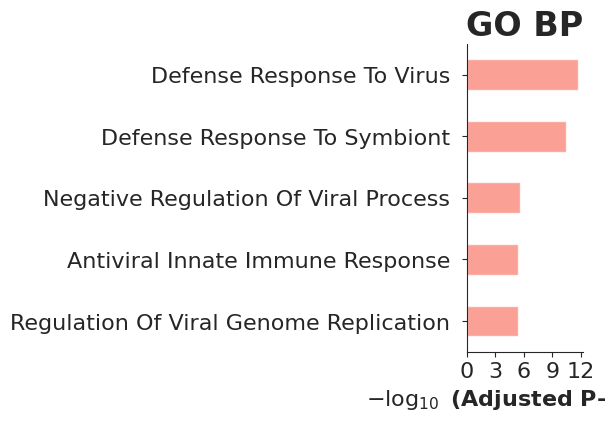

In [11]:
# concat results
enr_up.res2d['UP_DW'] = "UP"

enr_up_new = enr_up
enr_up_new.results["Term"] = [v.split("(GO:")[0] for v in enr_up_new.results["Term"].values]

ax = gp.barplot(enr_up_new.results,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                figsize=(1.5,4),
                color='salmon')
plt.tight_layout()
plt.savefig(f"plots/mechanism/unbiased_GOPBP_enrichment_NvF_Tcell_up.pdf",
           bbox_inches='tight')
plt.show()

### T cell (Strong vs Weak)

T cells with more pro-aging effects compared to T cells with less pro-aging effects

In [11]:
adata = large_load("results/for_imputation/SCPI_k4_k1/SVZDulken_spage_tangram_MI_EXTERNAL_TTEST_T cell_neighborhood_type_Strong",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [12]:
# get dataframe with p-values and t-statistics

df = adata.uns["spage_Strong_Weak_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Strong_Weak_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Strong_Weak_tstat"].T
df["Tangram t"] = adata.uns["tangram_Strong_Weak_tstat"].T

df.sort_values("SpaGE p")

,SpaGE p,Tangram p,SpaGE t,Tangram t
rpl29,0.000617,0.108842,3.424609,1.603426
rpl27a,0.000667,0.103776,3.403364,1.626820
rps21,0.000738,0.084664,3.375287,1.724247
rps13,0.000963,0.060242,3.301277,1.879020
rpl36a,0.001149,0.049797,3.251491,1.961708
...,...,...,...,...
tada1,0.999537,0.820604,-0.000580,0.226814
cfap74,0.999552,0.953477,0.000562,0.058383
a830010m20rik,0.999662,0.959311,-0.000424,0.051055
srgap3,0.999892,0.906567,-0.000136,-0.117419


In [14]:
# get lists of DEGs

# # p-value selection (permissive)
rejected = (df['SpaGE p']<0.05)&(df['Tangram p']<0.05)

# remove conflicting directions
rejected[(np.sign(df['SpaGE t'])!=np.sign(df['Tangram t']))] = False

# print DEGs
print("UP:")
sig_genes_up = df.index.values[rejected & (df['SpaGE t'].values>0)]
sig_genes_up = [x.capitalize() for x in sig_genes_up]
for gene in sig_genes_up:
    print(gene)

print("\nDOWN:")
sig_genes_down = df.index.values[rejected & (df['SpaGE t'].values<0)]
sig_genes_down = [x.capitalize() for x in sig_genes_down]
for gene in sig_genes_down:
    print(gene)

UP:
Ptpn18
Stk17b
Sp110
Bcl2
Rgs1
Cd48
Gm4955
Pyhin1
Mndal
Traf1
Dusp2
Zbp1
Il2rg
Rpl36a
Mbnl1
Fam189b
S100a4
S100a10
Cd2
Ptpn22
Gm12840
Lck
Fgl2
Gimap4
Gimap3
Gm9844
Rinl
Hcst
Cd37
Emp3
Isg20
Coro1a
Sept1
Lsp1
B4galnt1
Rps18-ps3
Cotl1
Rpl13-ps3
Lcp1
Epsti1
Thy1
Cd3d
Shisa5
Rpsa
Cd27
Cd52
Nkg7
Cd3g
Lat
Ptprc
Cd8b1
Cd8a

DOWN:


In [ ]:
cutoff = 0.1


# UP
enr_up = gp.enrichr(gene_list=list(sig_genes_up),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/SvW_Tcell_up",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_up.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=5,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

# DOWN
enr_down = gp.enrichr(gene_list=list(sig_genes_down),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/SvW_Tcell_down",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_down.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=5,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

/local/scratch/edsun/slrmtmp.42103730/ipykernel_6192/2557701524.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


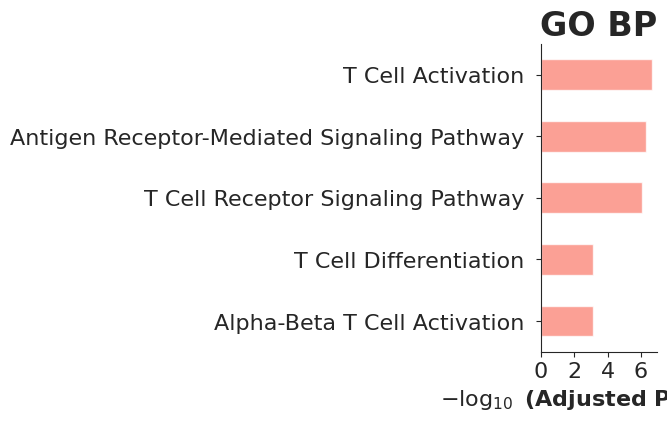

In [16]:
# concat results
enr_up.res2d['UP_DW'] = "UP"

enr_up_new = enr_up
enr_up_new.results["Term"] = [v.split("(GO:")[0] for v in enr_up_new.results["Term"].values]

ax = gp.barplot(enr_up_new.results,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                figsize=(1.5,4),
                color='salmon')
plt.tight_layout()
plt.savefig(f"plots/mechanism/unbiased_GOPBP_enrichment_SvW_Tcell_up.pdf",
           bbox_inches='tight')
plt.show()

### NSC (Near vs Far)

Target cells near NSCs compared to Target cells far from NSCs

In [23]:
# read in results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_proximity to NSC_Near",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [24]:
# get dataframe with p-values and t-statistics

df = adata.uns["spage_Near_Far_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Near_Far_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Near_Far_tstat"].T
df["Tangram t"] = adata.uns["tangram_Near_Far_tstat"].T

df.sort_values("SpaGE p")

,SpaGE p,Tangram p,SpaGE t,Tangram t
mt-nd2,0.000000,0.000000e+00,-9.035457,23.856141
mt-nd1,0.000000,0.000000e+00,-8.562601,24.180762
gm10561,0.000000,0.000000e+00,9.020152,14.613717
tcf7l2,0.000000,0.000000e+00,8.575409,15.064907
notch2,0.000000,0.000000e+00,8.535591,13.856352
...,...,...,...,...
stc1,0.999586,1.028663e-05,-0.000519,4.471105
dhx58,0.999756,1.469393e-02,-0.000306,2.451329
fam241a,0.999854,1.070888e-07,-0.000182,5.348858
d930030i03rik,0.999957,9.227382e-03,-0.000055,2.614973


In [25]:
# get lists of DEGs

# # p-value selection (permissive)
rejected = (df['SpaGE p']<0.05)&(df['Tangram p']<0.05)

# remove conflicting directions
rejected[(np.sign(df['SpaGE t'])!=np.sign(df['Tangram t']))] = False

# print DEGs
print("UP:")
sig_genes_up = df.index.values[rejected & (df['SpaGE t'].values>0)]
sig_genes_up = [x.capitalize() for x in sig_genes_up]
for gene in sig_genes_up:
    print(gene)

UP:
Lypla1
Tcea1
Rgs20
Rb1cc1
4732440d04rik
Rrs1
Adhfe1
Vcpip1
Sgk3
Prex2
Tram1
Lactb2
Eloc
Tmem70
Paqr8
Tmem14a
B3gat2
Smap1
Fam135a
Imp4
Fam168b
Plekhb2
Uggt1
Lman2l
Cnnm3
Coa5
Unc50
Pantr1
Pou3f3
Col5a2
Slc39a10
Inpp1
Hibch
Osgepl1
Asnsd1
Stk17b
Coq10b
Mob4
Rftn2
Gm10561
Maip1
Ndufb3
Cflar
Fzd7
Nbeal1
Raph1
Gm20342
Adam23
Creb1
Fzd5
Plekhm3
Idh1
Acadl
Atic
Igfbp5
Arpc2
Usp37
Plcd4
Stk16
Tuba4a
Dnpep
Acsl3
Utp14b
Serpine2
Mff
Pid1
Trip12
Itm2c
2810459m11rik
Psmd1
Ecel1
Prss56
Gigyf2
Ngef
Dgkd
Usp40
Arl4c
Hes6
Ndufa10
Stk25
Ing5
Gin1
Pam
2310035c23rik
Bcl2
Kdsr
Epb41l5
Steap3
Nckap5
Mgat5
Rab3gap1
R3hdm1
Ubxn4
Dars
Elk4
Mdm4
Ppp1r15b
Tmem183a
Arl8a
Gpr37l1
Rnpep
Timm17a
Tmem9
Zbtb41
Cdc73
B3galt2
Trove2
Rnf2
Tsen15
Rgl1
Ier5
Xpr1
Cep350
Tor1aip1
Tor1aip2
Soat1
Ralgps2
Mrps14
Prdx6
Prrc2c
Fmo1
Prrx1
Gm26523
Nme7
Atp1b1
Pou2f1
Ildr2
Aldh9a1
Ccdc190
Fcgr2b
Sdhc
Ndufs2
Dedd
Vangl2
Pex19
Dcaf8
Pigm
Fmn2
Fh1
Desi2
Sde2
Pycr2
Cnih4
Capn2
Brox
Aida
Marc2
Tgfb2
Ppp2r5a
G0s2
Cr1l
Nmt2
Frmd4a
Ph

In [26]:
print("\nDOWN:")
sig_genes_down = df.index.values[rejected & (df['SpaGE t'].values<0)]
sig_genes_down = [x.capitalize() for x in sig_genes_down]
for gene in sig_genes_down:
    print(gene)


DOWN:
Nkx2-9
Tmem117
Serpind1


2023-11-07 15:37:32,799 [INFO] Run: GO_Biological_Process_2023 
2023-11-07 15:37:39,165 [INFO] Save enrichment results for GO_Biological_Process_2023 
2023-11-07 15:37:39,538 [INFO] Done.


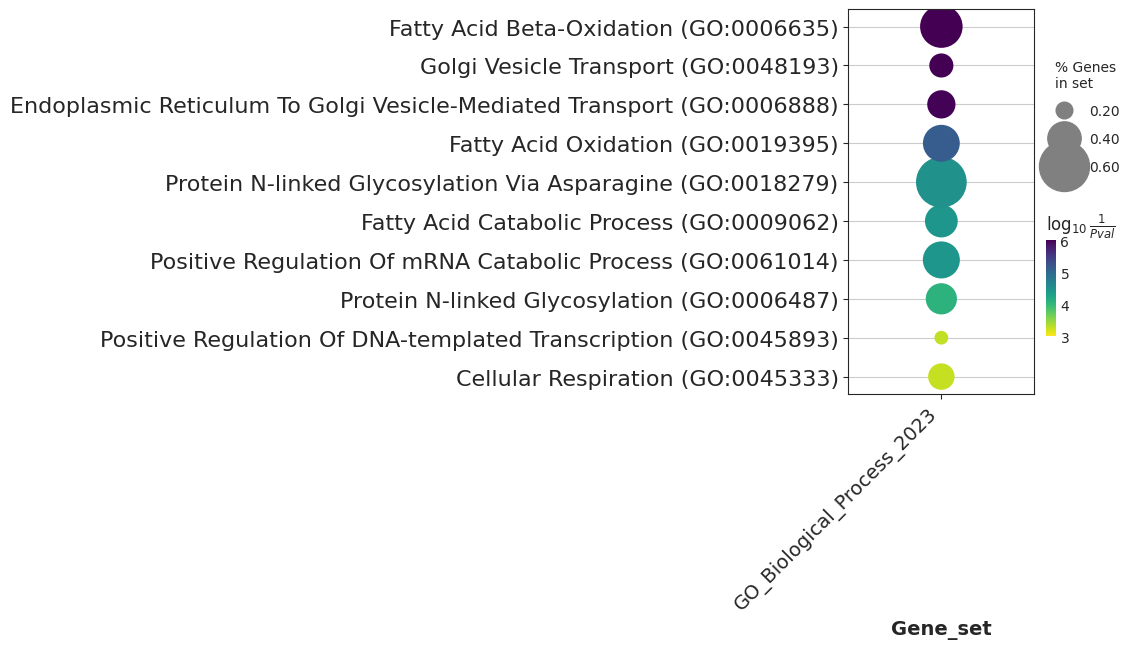

2023-11-07 15:37:40,399 [INFO] Run: GO_Biological_Process_2023 
2023-11-07 15:37:41,213 [INFO] Save enrichment results for GO_Biological_Process_2023 
2023-11-07 15:37:41,607 [INFO] Done.


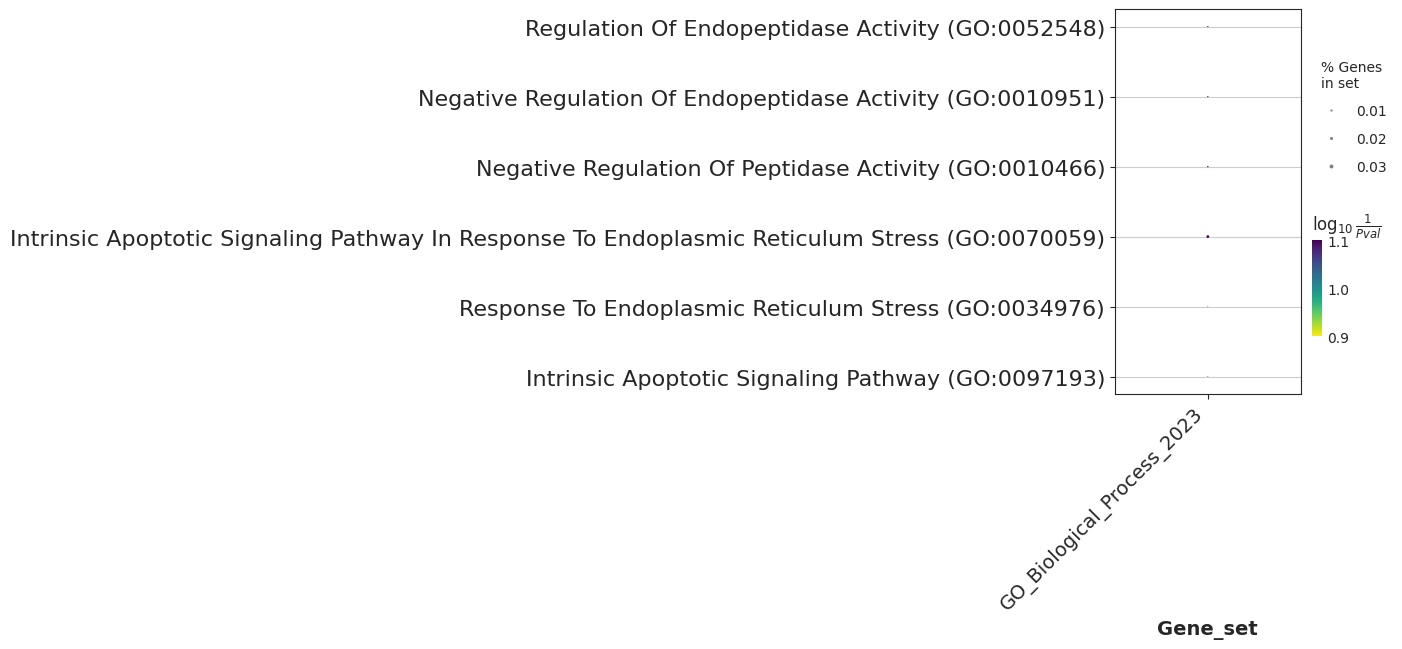

In [27]:
cutoff = 0.1


# UP
enr_up = gp.enrichr(gene_list=list(sig_genes_up),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/NvF_NSC_up",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_up.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=10,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

# DOWN
enr_down = gp.enrichr(gene_list=list(sig_genes_down),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             outdir=f"results/for_imputation/pathway_enrichment/NvF_NSC_down",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_down.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=10,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

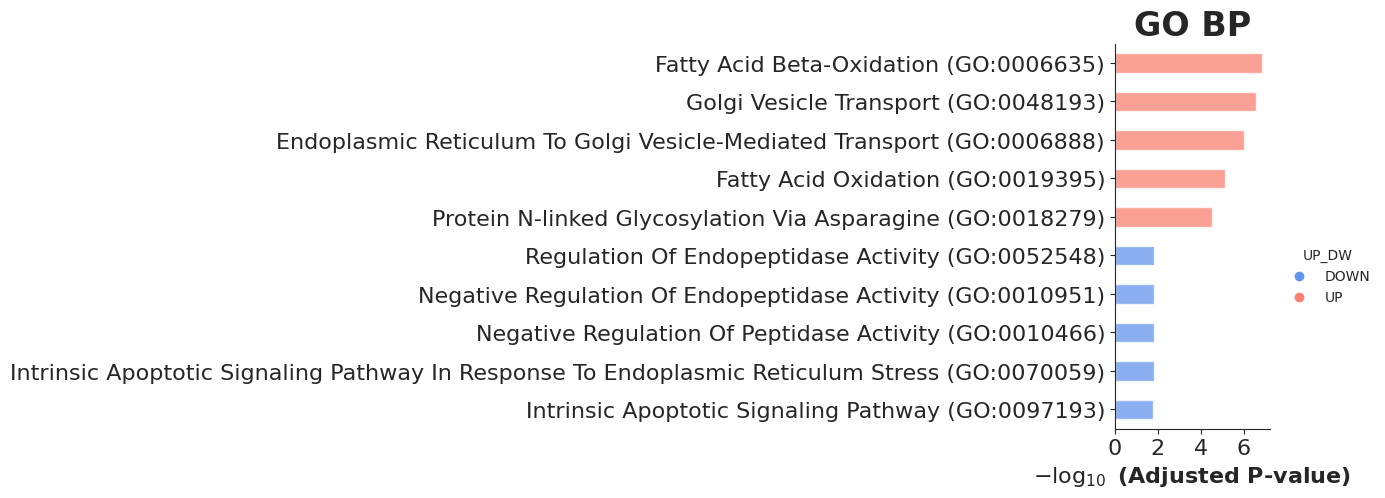

In [28]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_down.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_down.res2d.head()])


ax = gp.barplot(enr_res,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                group ='UP_DW',
                color = ['cornflowerblue','salmon'],
                figsize=(2,5))
plt.show()

/local/scratch/edsun/slrmtmp.42103730/ipykernel_4567/596169442.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


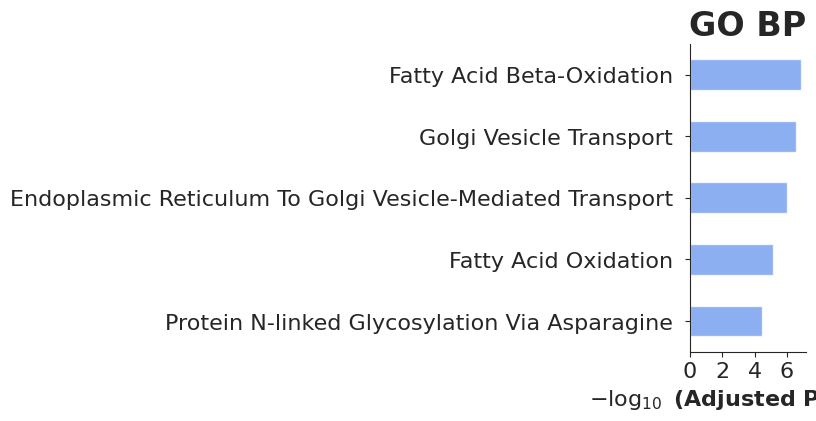

/local/scratch/edsun/slrmtmp.42103730/ipykernel_4567/596169442.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


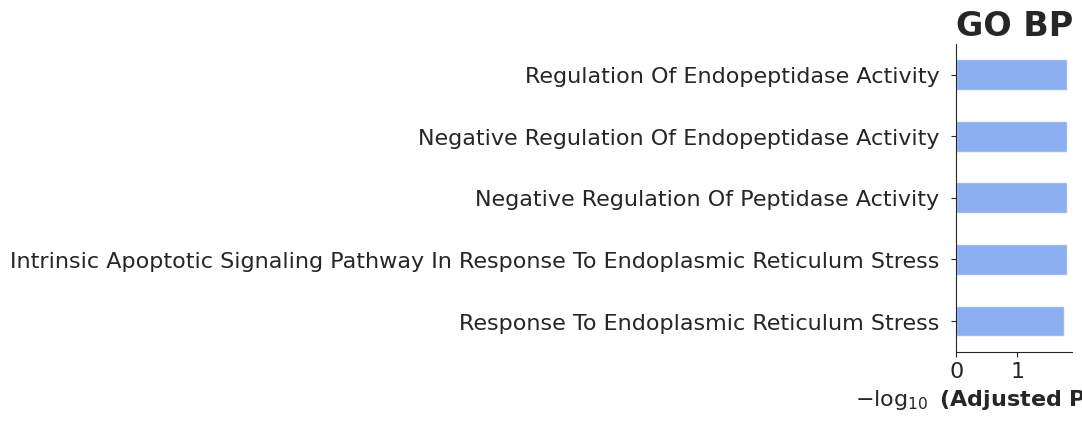

In [29]:
# concat results
enr_up.res2d['UP_DW'] = "UP"

enr_up_new = enr_up
enr_up_new.results["Term"] = [v.split("(GO:")[0] for v in enr_up_new.results["Term"].values]

ax = gp.barplot(enr_up_new.results,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                figsize=(1.5,4),
                color='cornflowerblue')
plt.tight_layout()
plt.savefig(f"plots/mechanism/unbiased_GOPBP_enrichment_NvF_NSC_up.pdf",
           bbox_inches='tight')
plt.show()


# concat results
enr_down.res2d['UP_DW'] = "DOWN"

enr_down_new = enr_down
enr_down_new.results["Term"] = [v.split("(GO:")[0] for v in enr_down_new.results["Term"].values]

ax = gp.barplot(enr_down_new.results,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                figsize=(1.5,4),
                color='cornflowerblue')
plt.tight_layout()
plt.savefig(f"plots/mechanism/unbiased_GOPBP_enrichment_NvF_NSC_down.pdf",
           bbox_inches='tight')
plt.show()

### NSC (Strong vs Weak)

NSCs with more pro-rejuvenating effects compared to NSCs with less pro-rejuvenating effects

In [10]:
# read in results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_EXTERNAL_TTEST_NSC_neighborhood_type_Strong",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [11]:
# get dataframe with p-values and t-statistics

df = adata.uns["spage_Strong_Weak_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Strong_Weak_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Strong_Weak_tstat"].T
df["Tangram t"] = adata.uns["tangram_Strong_Weak_tstat"].T

df.sort_values("SpaGE p")

,SpaGE p,Tangram p,SpaGE t,Tangram t
fdps,0.000002,1.110223e-15,4.773689,8.084252
dclk2,0.000046,0.000000e+00,4.080368,9.964569
fdft1,0.000088,0.000000e+00,3.939872,10.058477
hmgcs1,0.000093,1.176836e-14,3.919364,7.766638
rps27,0.000112,0.000000e+00,-3.865469,8.803879
...,...,...,...,...
tnni1,0.999615,2.274010e-01,0.000482,1.207571
ctf1,0.999657,3.665280e-02,-0.000430,2.094740
slc25a19,0.999692,1.562498e-07,-0.000386,5.292163
lgals2,0.999799,8.506696e-01,-0.000252,0.188362


In [13]:
df.sort_values("SpaGE p")

,SpaGE p,Tangram p,SpaGE t,Tangram t
fdps,0.000002,1.110223e-15,4.773689,8.084252
dclk2,0.000046,0.000000e+00,4.080368,9.964569
fdft1,0.000088,0.000000e+00,3.939872,10.058477
hmgcs1,0.000093,1.176836e-14,3.919364,7.766638
rps27,0.000112,0.000000e+00,-3.865469,8.803879
...,...,...,...,...
tnni1,0.999615,2.274010e-01,0.000482,1.207571
ctf1,0.999657,3.665280e-02,-0.000430,2.094740
slc25a19,0.999692,1.562498e-07,-0.000386,5.292163
lgals2,0.999799,8.506696e-01,-0.000252,0.188362


In [14]:
# get lists of DEGs

# # p-value selection (permissive)
rejected = (df['SpaGE p']<0.05)&(df['Tangram p']<0.05)

# remove conflicting directions
rejected[(np.sign(df['SpaGE t'])!=np.sign(df['Tangram t']))] = False

# print DEGs
print("UP:")
sig_genes_up = df.index.values[rejected & (df['SpaGE t'].values>0)]
sig_genes_up = [x.capitalize() for x in sig_genes_up]
for gene in sig_genes_up:
    print(gene)

print("\nDOWN:")
sig_genes_down = df.index.values[rejected & (df['SpaGE t'].values<0)]
sig_genes_down = [x.capitalize() for x in sig_genes_down]
for gene in sig_genes_down:
    print(gene)

UP:
St18
Mcm3
Ptp4a1
Zfp451
Pantr1
Pou3f3
Myo1b
Raph1
Idh1
Usp37
Epha4
Gpc1
Mcm6
Dars
Tmem183a
Glrx2
Rgs16
Pou2f1
Ndufs2
Usf1
Pex19
H3f3a
Cdc123
Vim
Med22
Psmb7
Kif5c
Rif1
Arl6ip6
Hat1
Dlx1as
Dlx2
Cdca7
Sp3
Ola1
Chn1
Mtx2
Mtch2
Mdk
Gm13889
Api5
Rad51
Dut
E2f1
Pfdn4
Nelfcd
Prelid3b
Lsm14b
Adrm1
Dnajc5
Polr3k
Plp2
Rbm3
Rbmx2
Arx
Pola1
Apoo
Maged1
Nono
Pou3f4
Bhlhb9
Impa1
Actl6a
Elf2
Ufm1
Commd2
Pfn2
Tsc22d2
Dclk2
Fdps
Rnf115
Ccne2
Mms22l
Map3k7
Casp8ap2
Mob3b
Chmp5
Vcp
Nans
Alg2
Nipsnap3b
Pole3
Cmpk1
Nasp
Med8
Ppih
Ctps
Sf3a3
Yrdc
Rbbp4
Zbtb8os
Khdrbs1
Snrnp40
Srsf4
Rpa2
Srsf10
Sdhb
Mfap2
Mad2l2
Cenps
Cyp51
Klhl7
Insig1
Tyms
Ppp1cb
Ctbp1
Slbp
Crmp1
Wdr1
Sel1l3
Uchl1
Paics
Dck
Sept11
Hnrnpdl
Rfc5
Fbxo21
Bcl7a
Vps37b
Chchd2
Rfc2
Mdh2
Ap1s1
Mcm7
Actb
Rfc3
Rpa3
Lsm8
Cycs
Pole4
Wbp1
Pcbp1
Copg1
Nr2c2
Lrrn1
Sec13
Raf1
Magohb
Strap
Golt1b
Sox5
Dennd5b
Tsen34
Peg3
Lig1
Ttc9b
Hnrnpl
Uba2
2410002f23rik
Bax
Tsg101
Ap3b2
Rrm1
Psma1
Sox6
Sbk1
Atxn2l
Ppp4c
Maz
Cd2bp2
Tbc1d10b
Mcmbp
Bccip
Tubgcp2
Psmd1

In [ ]:
cutoff = 0.1


# UP
enr_up = gp.enrichr(gene_list=list(sig_genes_up),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             #outdir=f"results/for_imputation/pathway_enrichment/SvW_NSC_up",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_up.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=10,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

# DOWN
enr_down = gp.enrichr(gene_list=list(sig_genes_down),
             gene_sets=["GO_Biological_Process_2023"],#, "KEGG_2019_Mouse", "Reactome_2022"],
             background=[x.capitalize() for x in df.index.values],
             organism="mouse",
             #outdir=f"results/for_imputation/pathway_enrichment/SvW_NSC_down",
             verbose=True,
             cutoff=cutoff)

ax = gp.dotplot(enr_down.results,
          column="Adjusted P-value",
          x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
          size=10,
          top_term=10,
          figsize=(3,5),
          xticklabels_rot=45, # rotate xtick labels
          marker='o',
          cutoff = cutoff
         )
plt.show()

/local/scratch/edsun/slrmtmp.42103730/ipykernel_4567/2661714791.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


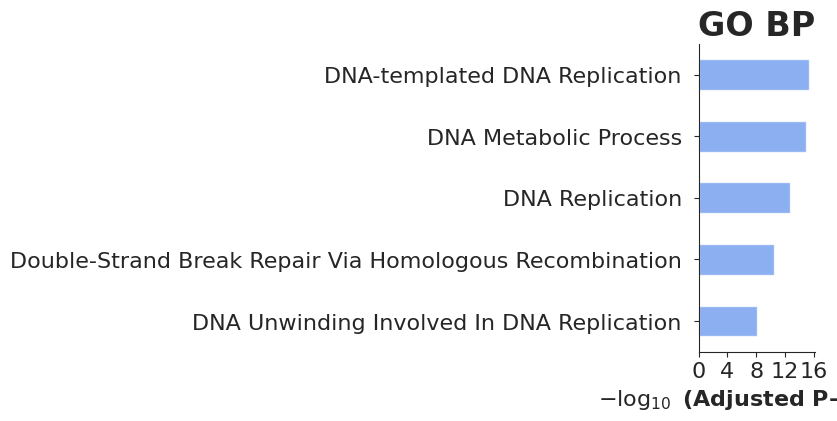

In [22]:
# concat results
enr_up.res2d['UP_DW'] = "UP"

enr_up_new = enr_up
enr_up_new.results["Term"] = [v.split("(GO:")[0] for v in enr_up_new.results["Term"].values]

ax = gp.barplot(enr_up_new.results,
                top_term=5,
                cutoff=0.05,
                title='GO BP',
                figsize=(1.5,4),
                color='cornflowerblue')
plt.tight_layout()
plt.savefig(f"plots/mechanism/unbiased_GOPBP_enrichment_SvW_NSC_up.pdf",
           bbox_inches='tight')
plt.show()